In [1]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

## MovieLense Dataset

Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [3]:
ratings = pd.read_csv('../data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [4]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [6]:
ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [8]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

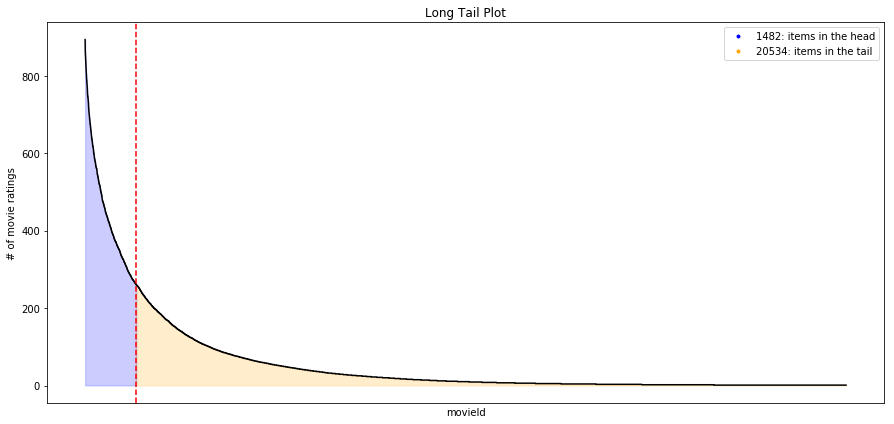

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

## Collaborative Filter Recommender

Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space.

In [10]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [11]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [12]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,14437,153,3.0,3.085193
1,24127,4953,3.0,3.106021
2,112049,42730,4.0,3.737146
3,92706,50447,3.5,3.725538
4,3284,8972,3.5,3.477276


In [14]:
#evaluate model with MSE and RMSE
print(recmetrics.mse(test.actual, test.cf_predictions))
print(recmetrics.rmse(test.actual, test.cf_predictions))

0.2654390018617308
0.5152077269041399


In [15]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [16]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [17]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[1198, 589, 1291, 3578, 593, 1270, 590, 4993, 1, 858]

In [18]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
recs = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

C:\Users\duygi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,actual,cf_predictions
userId,,
156,"[1, 4102, 2056, 10, 12, 2062, 15, 18, 21, 4118...","[1198, 589, 1291, 3578, 593, 1270, 590, 4993, ..."
208,"[3072, 1537, 69122, 54272, 4612, 3077, 517, 30...","[904, 6896, 593, 527, 905, 6783, 1104, 951, 12..."
359,"[1537, 33794, 515, 57353, 1546, 10, 3082, 5582...","[912, 1214, 953, 919, 50658, 6377, 1961, 3196,..."
394,"[54272, 3588, 6662, 6663, 4105, 1546, 10, 5582...","[111, 858, 1228, 1217, 1213, 745, 1945, 1267, ..."
572,"[516, 1029, 108548, 2571, 1036, 4621, 48142, 1...","[2028, 2571, 356, 593, 1036, 1291, 1198, 2858,..."


## Popularity Recommender

Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [19]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[1, 4102, 2056, 10, 12, 2062, 15, 18, 21, 4118...","[1198, 589, 1291, 3578, 593, 1270, 590, 4993, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[3072, 1537, 69122, 54272, 4612, 3077, 517, 30...","[904, 6896, 593, 527, 905, 6783, 1104, 951, 12...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[1537, 33794, 515, 57353, 1546, 10, 3082, 5582...","[912, 1214, 953, 919, 50658, 6377, 1961, 3196,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[54272, 3588, 6662, 6663, 4105, 1546, 10, 5582...","[111, 858, 1228, 1217, 1213, 745, 1945, 1267, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[516, 1029, 108548, 2571, 1036, 4621, 48142, 1...","[2028, 2571, 356, 593, 1036, 1291, 1198, 2858,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


## Random Recommender

Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [20]:
#make recommendations for all members in the test data

recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[1, 4102, 2056, 10, 12, 2062, 15, 18, 21, 4118...","[1198, 589, 1291, 3578, 593, 1270, 590, 4993, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[6287, 1485, 1642, 7123, 1214, 1952, 586, 3367..."
208,"[3072, 1537, 69122, 54272, 4612, 3077, 517, 30...","[904, 6896, 593, 527, 905, 6783, 1104, 951, 12...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[2012, 46948, 5222, 1747, 6581, 2369, 2857, 53..."
359,"[1537, 33794, 515, 57353, 1546, 10, 3082, 5582...","[912, 1214, 953, 919, 50658, 6377, 1961, 3196,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[4446, 172, 50742, 5026, 8044, 7218, 1438, 336..."
394,"[54272, 3588, 6662, 6663, 4105, 1546, 10, 5582...","[111, 858, 1228, 1217, 1213, 745, 1945, 1267, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[1676, 6989, 1429, 27611, 47894, 4720, 2279, 2..."
572,"[516, 1029, 108548, 2571, 1036, 4621, 48142, 1...","[2028, 2571, 356, 593, 1036, 1291, 1198, 2858,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[7482, 41716, 3556, 7079, 3105, 54001, 2944, 5..."


## Recall

In [21]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [22]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007995197185057852,
 0.0012368608155444692,
 0.0016441539144349206,
 0.0019804478927787556,
 0.002271270382754777,
 0.0025422556786377968,
 0.0027907091377966506,
 0.003009984264758056,
 0.0032316471877214935,
 0.003456232202627338]

In [23]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0002559410217328275,
 0.00040692362861356344,
 0.0005105479218000632,
 0.0005763964033189533,
 0.0006292514302201961,
 0.000693177925853512,
 0.0007439526770832008,
 0.0007802260167301731,
 0.0008255080899707211,
 0.0008585385304115289]

In [24]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.003075837914700693,
 0.006151675829401386,
 0.009227513744102078,
 0.012303351658802772,
 0.015379189573503461,
 0.018455027488204157,
 0.021530865402904848,
 0.024606703317605543,
 0.027682541232306235,
 0.030758379147006923]

## Mark Plot

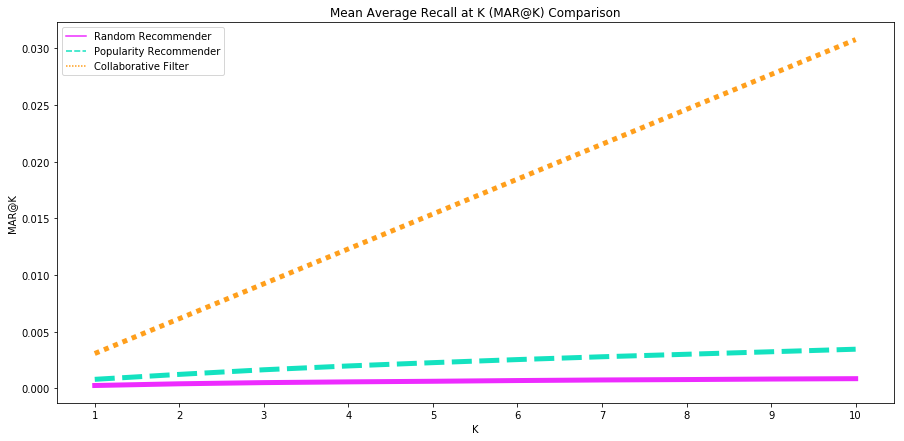

In [25]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

## Coverage

In [26]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

## Coverage Plot

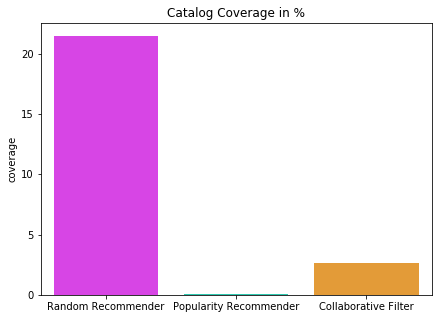

In [27]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

## Personalization

In [28]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [29]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

## Intra-list Similarity

In [30]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [31]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [32]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773

## Classification Probability Plot

In [37]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["predicted", "truth"]
pred_df.head()

,predicted,truth
0,0.496365,1.0
1,0.915364,1.0
2,0.818557,1.0
3,0.902105,1.0
4,0.660149,1.0


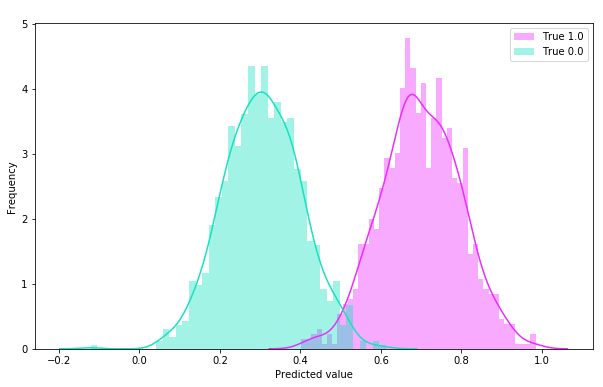

In [38]:
recmetrics.class_separation_plot(pred_df, n_bins=45)

## ROC Plot

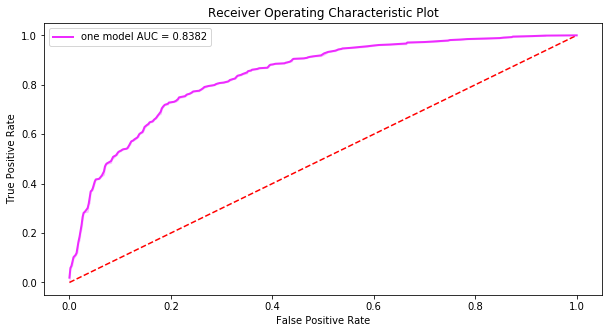

In [39]:
model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
actual = [0] * 500
class_zero_actual = [1] * 500
actual.extend(class_zero_actual)

recmetrics.roc_plot(actual, model_probs, model_names="one model",  figsize=(10, 5))

## Precision Recall Curve

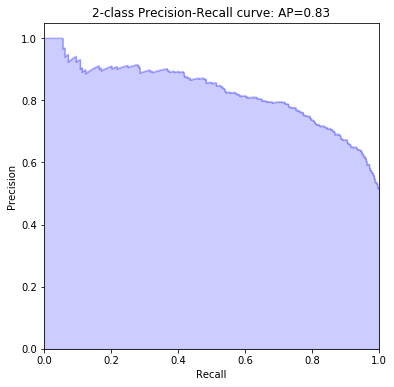

In [40]:
recmetrics.precision_recall_plot(targs=actual, preds=model_probs)

## Confusion Matrix

coming soon....

## Rank Order Analysis

coming soon....